# Data Mining 2026  — Project Notebook

**Course:** Data Mining  
**Project track:** [x] Standard Analysis [] Research-Oriented  
**Group members:**  
- Rasmus Skovgaard Pedersen 
- Hjalte Vilford Vinther
- Nour Mamoun Abdul Rahman Al Said

**Dataset:**  
**Initial task description (Module 1 perspective):**


## 0. Reproducibility and Setup

In [ ]:
import sys
print(sys.version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

3.11.14 | packaged by conda-forge | (main, Jan 27 2026, 00:00:54) [Clang 19.1.7 ]


## 1. Dataset Description and Loading

### 1.1 Dataset Overview

- Source:
- Number of instances:
- Number of features / entities:
- Missing values:
- Basic statistics:


In [46]:
# Load dataset
data_path = os.path.join("data", "raw", "Online_Retail.csv")
data = pd.read_csv(data_path, encoding='ISO-8859-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


### Exploratory Data Analysis
- Basic statistics
- Distributions
- Sparsity / density

### Cleaning & Transformations
- Handling missing values
- Feature engineering
- Graph construction (if Checkpoint 2)

Justify design decisions.

In [47]:
#First lets look at the number of rows and columns, as well as the datatypes, as well as the number of non-null values in each column.
data.info()
#We can also look at the number of missing values in each column.
data.isnull().sum()

<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 33.1 MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [48]:
#Lets look at some basic statistics for numeric columns (quantity, unitprice), we ignore the customerid column, as it is a number but its not relavant to look at statistics for it.
data_no_customer = data.drop(columns=['CustomerID'])
data_no_customer.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [49]:
#Lets also generate a categorical overview
print(data["Country"].value_counts())
print("Unique CustomerIDs:", data["CustomerID"].nunique())
print("Unique StockCodes:", data["StockCode"].nunique())
print("Unique InvoiceNos:", data["InvoiceNo"].nunique())

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


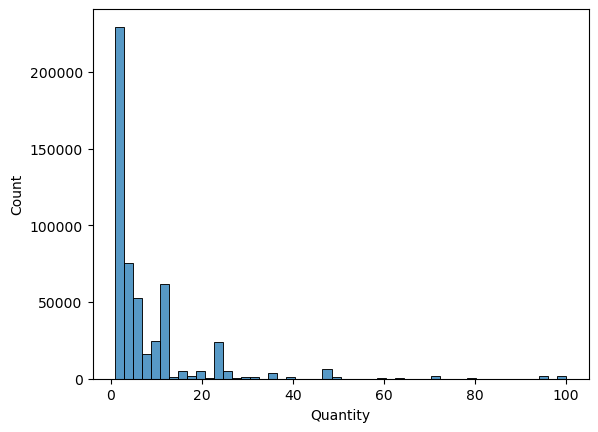

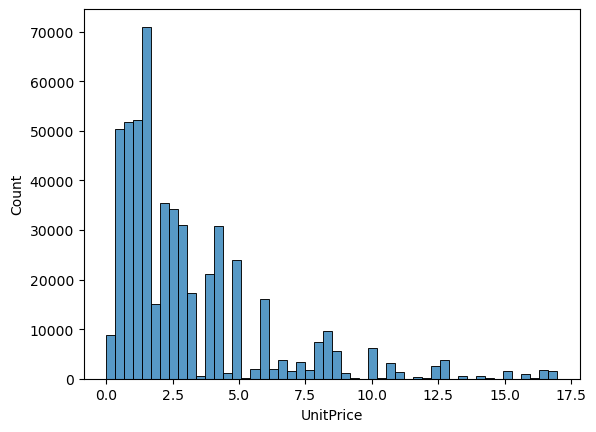

In [77]:
#Now lets take a look some distributions, starting with quantity and unitprice, as these are the most relevant numeric columns for our analysis, and they are also the ones with the most outliers, which makes it interesting to look at their distribution.:
#Since we have some pretty extreme outliers, we will will limit it to positive values, and then we will look at the distribution of the values that are below the 99th percentile, to get a better understanding of the distribution of the data without the influence of the extreme outliers.
df_clean = data[
    (data["Quantity"] > 0) &
    (data["UnitPrice"] > 0)
]
q_upper = df_clean["Quantity"].quantile(0.99)
p_upper = df_clean["UnitPrice"].quantile(0.99)

sns.histplot(df_clean[df_clean["Quantity"] <= q_upper]["Quantity"], bins=50)
plt.show()

sns.histplot(df_clean[df_clean["UnitPrice"] <= p_upper]["UnitPrice"], bins=50)
plt.show()

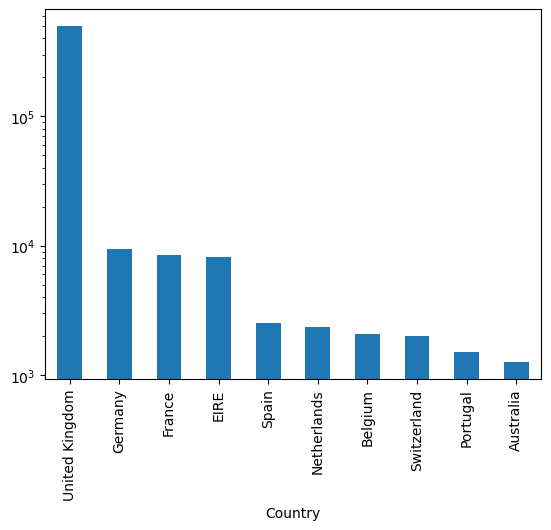

In [80]:
#We can also look at the distribution of the countries, to see which countries have the most transactions.
#We log scale the y-axis, as the amount of transactions are heavily dominated by the UK, which makes it hard to see the distribution of the other countries.
data["Country"].value_counts().head(10).plot(kind="bar")
plt.yscale("log")
plt.show()

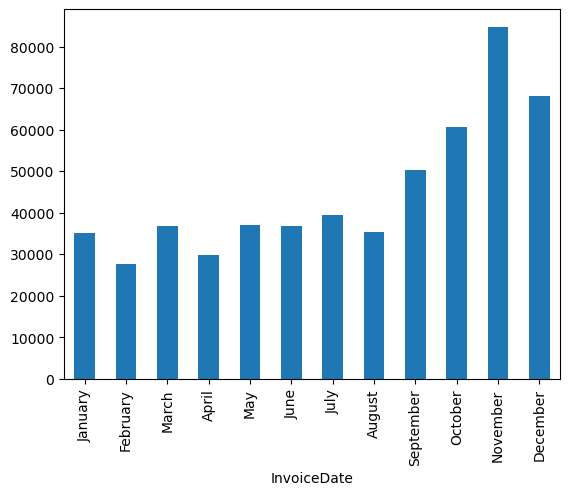

In [83]:
#We can also look at the distribution of the dates the orders where put.
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["InvoiceDate"].dt.month_name().value_counts().reindex(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]).plot(kind="bar")
plt.show()

In [87]:
#Now lets look at the sparsity and density of the data.
#First lets create a Customer–Product Matrix.
pivot = data.pivot_table(index="CustomerID",
                       columns="StockCode",
                       values="Quantity",
                       aggfunc="sum",
                       fill_value=0)

#Now we count the number of non-zero values in the pivot table, and divide it by the total number of values in the pivot table to get the density, and then we can calculate the sparsity as 1 - density.
non_zero = np.count_nonzero(pivot)
total = pivot.size

density = non_zero / total
sparsity = 1 - density

print("Density:", density)
print("Sparsity:", sparsity)


Density: 0.01652207861100101
Sparsity: 0.983477921388999


In [91]:
#For our project as we would like to look at revenue we can create a revenue collumn
data["Revenue"] = data["Quantity"] * data["UnitPrice"]
data["Revenue"].describe()

count    541909.000000
mean         17.987795
std         378.810824
min     -168469.600000
25%           3.400000
50%           9.750000
75%          17.400000
max      168469.600000
Name: Revenue, dtype: float64

## 2. Module 1 — Vector-Space Analysis

### 2.1 Vector Representation

Explain your feature construction and distance measure here.

In [51]:
# Construct vector representation
X = None  # Replace with actual feature matrix

### 2.2 Clustering Method

In [52]:
# Implement clustering algorithm here
labels = None

## 3. Module 2 — Graph-Based Analysis

In [53]:
import networkx as nx

# Build graph
G = nx.Graph()

ModuleNotFoundError: No module named 'networkx'

## 4. Module 3 — Pattern / Text Mining

In [ ]:
# Pattern mining implementation
patterns = None

## 5. Final Synthesis and Reflection

- Key insights:
- Limitations:
- Revisions after feedback:
